# GFS Forecast Maps from Thredds Server via NCSS and Siphon
# MSLP w/ Highs and Lows and Thickness

## Justin Richling
## 11/15/18

https://doi.org/10.6084/m9.figshare.5244637.v1

In [1]:
# Random Library Imports
import subprocess,os,glob,tempfile,re,webbrowser,io,sys,types,\
time

# Importing Datetime Libraries
from datetime import datetime, timedelta

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj 

# Numerical and Scientific Libraries
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

# Accessing Data from External Databases via XLM Catalog
from siphon.ncss import NCSS
from siphon.catalog import TDSCatalog

# MetPy Libraries
import metpy
import metpy.calc as mpcalc
from metpy.units import masked_array, units
from metpy.plots import ctables
from metpy.plots import add_metpy_logo
from metpy.constants import g

# NetCDF Libraries
from netCDF4 import Dataset
from netCDF4 import num2date

# More Image Manipulation Options
from PIL import Image as PILImage
from IPython.display import Image

# Ipyhton Options
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML, display, Image

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LinearSegmentedColormap

# Warnings
import warnings
warnings.filterwarnings('ignore')

#import ColorBar


/Users/chowdahead/miniconda3/lib/python3.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [2]:
# Set the font 
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

## Helper Functions

In [3]:
# Thanks to the crew over at Metpy for this handy little function
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [4]:
# MetPy Function
def plot_maxmin_points(AX,lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)
    #print mxy,mxx

    for i in range(len(mxy)):
        #ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
        #        clip_on=True, horizontalalignment='center', verticalalignment='center',
        #        transform=transform)
        #ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
        #        '\n' + str(np.int(data[mxy[i], mxx[i]])),
        #        color=color, size=12, clip_on=True, fontweight='bold',
        #        horizontalalignment='center', verticalalignment='top', transform=transform)
        
        AX.text(lon[mxx[i]], lat[mxy[i]], symbol, color=color, size=24,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        AX.text(lon[mxx[i]], lat[mxy[i]],
                '\n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set the Map Projection

In [5]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Set a list for the 24 hour forecast time steps

In [6]:
now = datetime.utcnow()
#now = datetime(2019,2,7,18,0)
today_day = int('{0:%d}'.format(now))
today_year = int('{0:%Y}'.format(now))
today_month = int('{0:%m}'.format(now))
print(today_day,today_year,today_month)

forecast_times = []
forecast_times.append(now)
#for i in range(4,8):
#    forecast_times.append(datetime(today_year,today_month,today_day,i*3,0))
#for i in range(0,5):
#    forecast_times.append(datetime(today_year,today_month,today_day+1,i*3,0))
forecast_times

12 2019 3


[datetime.datetime(2019, 3, 12, 20, 17, 29, 501691)]

<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Figure out where the saved maps will go

In [7]:
# Set a path to save the plots with string format for the date to set the month and day
im_save_path ="/path/to/saved/images/"
print(im_save_path)

# Check to see if the folder already exists, if not create it
if not os.path.isdir(im_save_path):
    os.makedirs(im_save_path)

# Uncomment if you want to automatically change to the map folder    
#os.chdir(im_save_path)

/Users/ChowdaHead/Desktop/Weather_Blog/Examples/


<h2>----------------------------------------------//---------------------------------------------------------</h2>

## Start at the top of the thredds catalog

In [8]:
from siphon.catalog import TDSCatalog
top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
ref = top_cat.catalog_refs['Forecast Model Data']
new_cat = ref.follow()
model = new_cat.catalog_refs[4]
gfs_cat = model.follow()
ds = gfs_cat.datasets[1]
print("Variable Name:",ds.name)
print("Path:",ds.url_path)

Variable Name: Best GFS Quarter Degree Forecast Time Series
Path: grib/NCEP/GFS/Global_0p25deg/Best


<h2>----------------------------------------------//---------------------------------------------------------</h2>
<h2>----------------------------------------------//---------------------------------------------------------</h2>

<h1><font style="font-size:32px"><center>-- Plotting all of the GFS forecast hours for the current day --</center></font></h1>

<h2><font><center>-- Highs/Lows and 1000-500mb Thickness --</center></font></h2>

2019_03_12_21Z


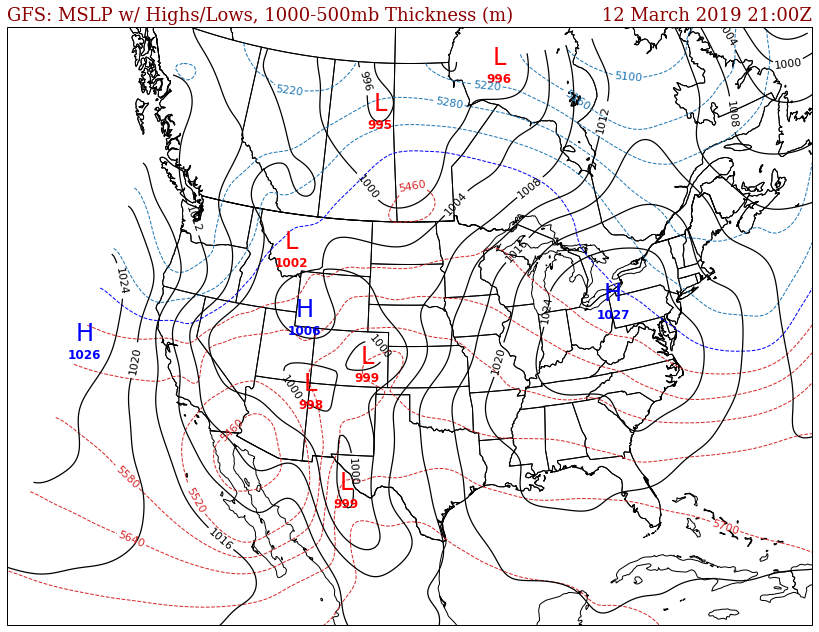

done.


In [9]:
for i in forecast_times:
    ds = gfs_cat.datasets[1]
    subset = ds.subset()
    query_data = subset.query()
    query_data.lonlat_box(west=-130, east=-50, south=10, north=60)

# Allow for NetCDF files
    query_data.accept('netcdf4')
    query_data.time(i)
    data = query_data.variables('Geopotential_height_isobaric',
               'Pressure_reduced_to_MSL_msl')

# Finally attempt to access the data
    data = subset.get_data(query_data)
    
# Grab pressure levels
    plev = list(data.variables['isobaric'][:])

# Grab lat/lons and make all lons 0-360
    lats = data.variables['lat'][:]
    lons = data.variables['lon'][:]
    lons[lons < 0] = 360 + lons[lons < 0]

# Grab MSLP and smooth, use MetPy Units module for conversion
    EMSL = data.variables['Pressure_reduced_to_MSL_msl'][:] * units.Pa
    EMSL.ito('hPa')
    mslp = gaussian_filter(EMSL[0], sigma=3.0)

# Grab pressure level data
    hght_1000 = data.variables['Geopotential_height_isobaric'][0, plev.index(100000.0)]
    hght_500 = data.variables['Geopotential_height_isobaric'][0, plev.index(50000.0)]
#mb500 = data.variables['Geopotential_height_isobaric'][0,::plev.index(50000.0)]*units.Pa
#mb500.ito('hPa')
    Height500mb = gaussian_filter(hght_500[0], sigma=3.0)

# Calculate and smooth 1000-500 hPa thickness
    thickness_1000_500 = gaussian_filter(hght_500 - hght_1000, sigma=3.0)
    
# Convert number of hours since the reference time into an actual date
    time_var = data.variables[find_time_var(data.variables['Pressure_reduced_to_MSL_msl'])]
    time_final = num2date(time_var[:].squeeze(), time_var.units)
    print(str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z")
    file_time = str(time_final)[:4]+"_"+str(time_final)[5:7]+"_"+str(time_final)[8:10]+"_"+str(time_final)[11:13]+"Z"    
    
# Create new figure
    fig = plt.figure(figsize=(17., 11.))

    add_metpy_logo(fig, 30, 940, size='small')

# Add the map 
    ax = plt.subplot(111, projection=plotcrs)

# Set extent and plot map lines
    ax.set_extent(extent, datacrs)
#ax.set_extent([-75, -30.5, 0.5, 28.5])

# Add state boundaries to plot
    ax.add_feature(states_provinces, edgecolor='k', linewidth=1)

# Add country borders to plot
    ax.add_feature(country_borders, edgecolor='black', linewidth=1)

# Plot Title
    plt.title('GFS: MSLP w/ Highs/Lows, 1000-500mb Thickness (m)', loc='left',fontdict=font)
    plt.title(' {0:%d %B %Y %H:%MZ}'.format(time_final), loc='right',fontdict=font)

                                            # 1000-500mb Thickness
#---------------------------------------------------------------------------------------------------
    clevs = (np.arange(0, 5400, 60), np.arange(5400,5401,1), np.arange(5460, 7000, 60))
    colors = ('tab:blue', 'b', 'tab:red')
    kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
    for clevthick, color in zip(clevs, colors):
        cs = ax.contour(lons, lats, thickness_1000_500, levels=clevthick, colors=color,
                    linewidths=1.0, linestyles='dashed', transform=datacrs)
        plt.clabel(cs, **kw_clabels)

                                            # MSLP
#---------------------------------------------------------------------------------------------------
    clevmslp = np.arange(800., 1120., 4)
    cs2 = ax.contour(lons, lats, mslp, clevmslp, colors='k', linewidths=1.25,
                 linestyles='solid', transform=datacrs)
    plt.clabel(cs2, **kw_clabels)

                                            # High and Low Symbols
#---------------------------------------------------------------------------------------------------
    plot_maxmin_points(ax,lons, lats, mslp, 'max', 50, symbol='H', color='b',  transform=datacrs)
    plot_maxmin_points(ax,lons, lats, mslp, 'min', 25, symbol='L', color='r', transform=datacrs)
    
    plt.show()
    GFS_HILO = im_save_path+"GFS/HILO/"
    if not os.path.isdir(GFS_HILO):
        os.makedirs(GFS_HILO)
    outfile=GFS_HILO+"HL_Thickness_Model_"+file_time+".png"
    fig.savefig(outfile,bbox_inches='tight',dpi=120)
    plt.close(fig)
print("done.")

<h2>----------------------------------------------//---------------------------------------------------------</h2>